In [7]:
# import yaml
# with open('config.yaml', 'r') as f:
#     config = yaml.safe_load(f)
import config
import json
import numpy as np
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Read from JSON
with open('config.json', 'r') as f:
    config = json.load(f)

# Convert lists back to NumPy arrays for the norms
if 'norms' in config:
    config['norms'] = {
        key: np.array(value) for key, value in config['norms'].items()
    }

print(config)

{'datapath': '/home/jw8736/mlflux/data/Processed/', 'datafile': 'psd_coare3p0_weight1_wave0.nc', 'ann_size': [64, 32, 16], 'mean_activation': 'no', 'var_activation': 'exponential', 'ikeys': ['U', 'tsea', 'tair', 'rh'], 'okeys': ['taucx'], 'bkeys': ['taubx'], 'NRAND': 5, 'RATIO': 0.2, 'WEIGHT': True, 'RESIDUAL': False, 'training_paras': {'batchsize': 1000, 'num_epochs': 500, 'lr': 0.0005, 'gamma': 0.2, 'EARLYSTOPPING': False, 'patience': 20, 'factor': 0.5, 'max_epochs_without_improvement': 100}, 'compute_norm': True, 'norms': {'imean': array([0, 0, 0, 0]), 'iscale': array([ 20,  20,  20, 100]), 'omean': array([0]), 'oscale': array([0.1])}, 'two_steps': False, 'VERBOSE': True}


In [103]:
import torch
import numpy as np
import xarray as xr
from mlflux.datafunc import data_split_psd_rand
from mlflux.ann import RealFluxDataset
from mlflux.predictor import FluxANNs

path = './'
    
datapath = config.datapath
datafile = config.datafile

ann_size = config.ann_size
mean_activation = config.mean_activation
var_activation = config.var_activation

ikeys = config.ikeys
okeys = config.okeys
bkeys = config.bkeys

NRAND = config.NRAND
RATIO = config.RATIO

WEIGHT = config.WEIGHT
RESIDUAL = config.RESIDUAL

training_paras = config.training_paras
# {'batchsize':1000, 'num_epochs':500, 'lr':5e-4, 'gamma':0.2, 
# 'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':100}

compute_norm = config.compute_norm
norms = config.norms
# {'imean':np.array([0,0,0,0]), 'iscale':np.array([20,20,20,100]), 
# 'onorm_mean':np.array([0]), 'oscale':np.array([0.1])} 

# TODO: remains to be tested
VERBOSE = config.VERBOSE
two_steps = config.two_steps

###### Load data #######
ds = xr.load_dataset(datapath + datafile)
if WEIGHT:
    if 'weight' not in ds.data_vars:
        print(f"Weights don't exist! Check config file.")
        sys.exit(1)
else:
    ds['weight'] = ds['U']/ds['U'] # manually set to 1 

###### Put together network parameters #######
para_mean = {'n_in':len(ikeys),'n_out':len(okeys),'hidden_channels':ann_size,'ACTIVATION':mean_activation}
para_var = {'n_in':len(ikeys),'n_out':len(okeys),'hidden_channels':ann_size,'ACTIVATION':var_activation}

###### Assemble dataloader #######
rand_seed = 1
training_ds, validating_ds, testing_ds = data_split_psd_rand(ds, seed=rand_seed, ratio=RATIO)
training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
###### Initialize model weights ######
model = FluxANNs({'mean_ann_para':para_mean, 'var_ann_para':para_var})
###### Compute or read scales #######
if compute_norm:
    xmean_value = (training_data.X*training_data.W).mean(dim=0) # scales also need to be weighted
    xscale_value = ((training_data.X - xmean_value)**2*training_data.W).mean(dim=0)**0.5            
    ymean_value = (training_data.Y*training_data.W).mean(dim=0) # scales also need to be weighted
    yscale_value = ((training_data.Y - ymean_value)**2*training_data.W).mean(dim=0)**0.5
    model.Xscale = {'mean':xmean_value.reshape(1,-1),
                    'scale':xscale_value.reshape(1,-1)}          
    model.Yscale = {'mean':ymean_value.reshape(1,-1),
                    'scale':yscale_value.reshape(1,-1)}
else:   
    if (len(norms['imean']) == len(ikeys)) and (len(norms['omean']) == len(okeys)):
        model.Xscale = {'mean':torch.tensor(norms['imean'].reshape(1,-1).astype('float32')),
                        'scale':torch.tensor(norms['iscale'].reshape(1,-1).astype('float32'))}      
        model.Yscale = {'mean':torch.tensor(norms['omean'].reshape(1,-1).astype('float32')),
                        'scale':torch.tensor(norms['oscale'].reshape(1,-1).astype('float32'))}
    else:
        print(f"Read in normalization does not match network size!")
        sys.exit(1)                
    
log = model.fit(training_data, validating_data, training_paras, VERBOSE=VERBOSE, TWOSTEPS=two_steps)
# model.save(fname=path + "model_rand%g" %rand_seed) 

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Mean training took 40.09 seconds.
Variance training took 88.69 seconds.


Text(0.5, 0, 'Epochs')

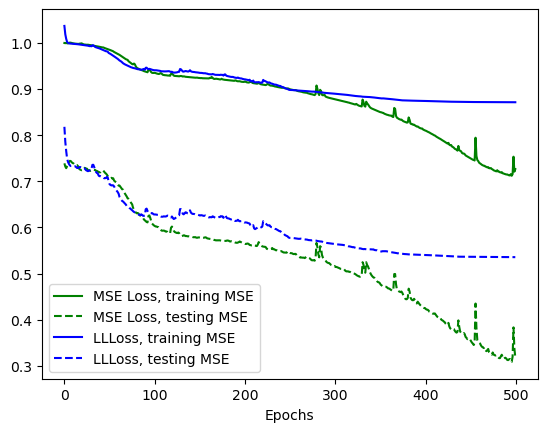

In [100]:
plt.plot(model_twosteps.log[0]['t_mse'], c='g', label='MSE Loss, training MSE')
plt.plot(model_twosteps.log[0]['v_mse'], c='g', ls='--', label='MSE Loss, testing MSE')
plt.plot(model.log['t_mse'], c='b', label='LLLoss, training MSE')
plt.plot(model.log['v_mse'], c='b', ls='--',  label='LLLoss, testing MSE')
plt.legend()
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

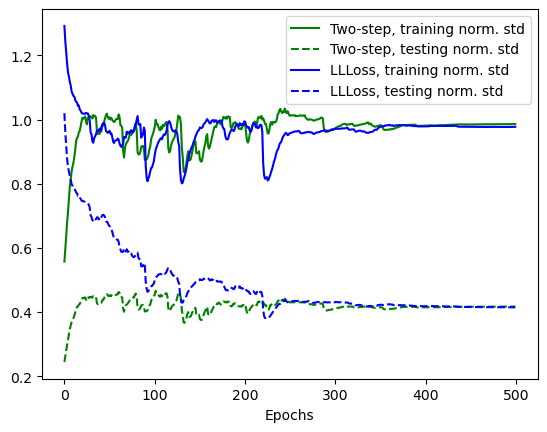

In [102]:
plt.plot(model_twosteps.log[1]['t_resvar'], c='g', label='Two-step, training norm. std')
plt.plot(model_twosteps.log[1]['v_resvar'], c='g', ls='--', label='Two-step, testing norm. std')
plt.plot(model.log['t_resvar'], c='b', label='LLLoss, training norm. std')
plt.plot(model.log['v_resvar'], c='b', ls='--',  label='LLLoss, testing norm. std')
plt.legend()
plt.xlabel('Epochs')

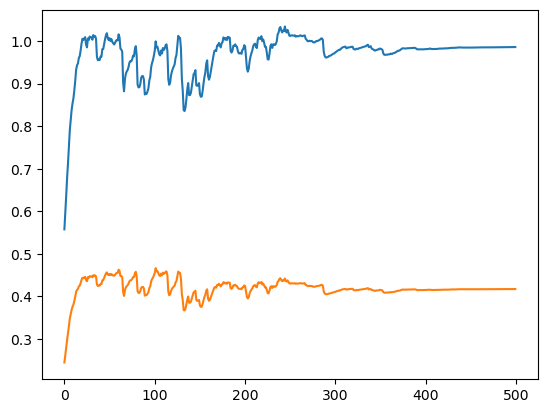

In [92]:
plt.plot(model.log[1]['t_resvar'])
plt.plot(model.log[1]['v_resvar'])

In [94]:
model_twosteps = model